Stress test:
- There are 5531452 rows in the csv file in total (including header)
- It takes 3m31s to read train_data.csv

In [1]:
# N = sum(1 for line in open('data/train_data.csv'))
# N
# print(sum(1 for line in open('data/train_labels.csv')))

In [2]:
# df = pd.read_csv('data/train_data.csv')
# labels = pd.read_csv('data/train_labels.csv')

## Setup

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

In [41]:
features = pd.read_csv('data/train_data.csv')
labels = pd.read_csv('data/train_labels.csv')

In [3]:
data_points = features.groupby('customer_ID').count()

In [7]:
for i in range(14):
    print(i, len(data_points['S_2'].loc[data_points['S_2'] == i]))

0 0
1 5120
2 6098
3 5778
4 4673
5 4671
6 5515
7 5198
8 6110
9 6411
10 6721
11 5961
12 10623
13 386034


#### Categorize columns by type: 

In [4]:
features.dtypes.unique()

array([dtype('O'), dtype('float64'), dtype('int64')], dtype=object)

In [5]:
obj_cols = features.select_dtypes(include=['O']).columns
obj_cols

Index(['customer_ID', 'S_2', 'D_63', 'D_64'], dtype='object')

In [6]:
int_cols = features.select_dtypes(include=['int64']).columns
int_cols

Index(['B_31'], dtype='object')

In [7]:
print('B_31', features.B_31.unique())
for col in obj_cols.drop(['customer_ID', 'S_2']): # S_2 is a date
    print(col, features[col].unique())

B_31 [1 0]
D_63 ['CR' 'CO' 'CL' 'XZ' 'XM' 'XL']
D_64 ['O' 'R' nan 'U' '-1']


In [8]:
float_cols = features.select_dtypes(include=['float64']).columns
float_cols

Index(['P_2', 'D_39', 'B_1', 'B_2', 'R_1', 'S_3', 'D_41', 'B_3', 'D_42',
       'D_43',
       ...
       'D_136', 'D_137', 'D_138', 'D_139', 'D_140', 'D_141', 'D_142', 'D_143',
       'D_144', 'D_145'],
      dtype='object', length=185)

In [9]:
nullcols = []
for col in features:
    if features[col].isnull().values.any():
        nullcols.append(col)
len(nullcols)

122

#### Generate distribution histograms of the columns:

In [10]:
###
# features.hist(bins=20, figsize=(60, 40))
###

## Preprocessing

#### Useful utility functions:

In [2]:
def get_sample(size):
    # gets (size) amount of customers
    prng = np.random.RandomState(0)
    g = features.groupby('customer_ID')

    portion = features[g.ngroup().isin(prng.choice(g.ngroups, size, replace=False))]
    return portion

# sample1 = get_sample(len(labels)//100)
# sample2 = get_sample(1000)
sample1 = pd.read_csv('data/sample1.csv').set_index('sampled_index')

In [4]:
# sample1.to_csv('./data/sample1.csv')

In [3]:
def get_y(ids):
    label_lookup = dict()
    for id in ids:
        if id not in label_lookup:
            target = labels.loc[labels.customer_ID == id, 'target']
            label_lookup[id] = target.iloc[0]

    return pd.Series([label_lookup[id] for id in ids], index=ids)
    # for id in features.customer_ID.unique():
    #     if len(features.loc[features.customer_ID == id, 'target'].unique()) != 1:
    #         print(features.loc[features.customer_ID == id])
    
# sample_y = get_y(sample1['customer_ID'])
labels = pd.read_csv('data/sample1_labels.csv')

In [6]:
# sample_y.to_csv('./data/sample1_labels.csv')

In [4]:
sample1['S_2'] = pd.to_datetime(sample1['S_2'], format='%Y-%m-%d')

#### Potential Pipeline:
- Apply OHE/MEstimate
- Combine IDs
- Impute missing values
- (PCA)
- (KMeans)
- Train
- Predict
- Cross validate

#### Data Imputation:

Note all transformers written assumes customer_ID as the index

In [5]:
from lib2to3.pytree import Base
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sqlalchemy import Column

class ByIndexTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, transformer, cnames = None):
        self.cnames = cnames
        self.transformer = transformer
    def fit(self, X: pd.DataFrame, y = None):
        self.fitted_transformers = X.groupby(X.index).apply(
            lambda df: self.transformer.fit(df if self.cnames == None else df[self.cnames]))
        self.fitted_transformers = {self.fitted_transformers.index[i] : self.fitted_transformers.iloc[i] for i in range(len(self.fitted_transformers))}
        return self
    def transform(self, X: pd.DataFrame, y = None):
        transformed = X.groupby(X.index).apply(
            lambda df: pd.DataFrame(
                self.fitted_transformers[df.index[0]]
                .transform(df if self.cnames == None else df[self.cnames])
            )
        )
        transformed.reset_index()
        transformed.index = X.index
        return transformed

class IDFoldTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, id_name = None):
        self.id_name = id_name
    def fit(self, X: pd.DataFrame, y = None):
        return self
    def transform(self, X: pd.DataFrame, y = None):
        return X.groupby(X.index if self.id_name == None else self.id_name).apply(lambda df: df.mean()).unstack().reset_index()
        
###
# class DFTransformer(BaseEstimator, TransformerMixin):
#     def __init__(self, cnames)

# # class EncoderWrapper(BaseEstimator, TransformerMixin):
# #     def __init__(self, encoder):
# #         self.encoder = encoder
# #     def fit(self, X: np.ndarray, y = None):
# #         self.encoder.fit(X, y)
# #         return self
# #     def transform(self, X: np.ndarray, y = None):
# #         encoded_cols = self.encoder.transform(X)
# #         encoded_df = pd.DataFrame(encoded_cols)
# #         return encoded_df

# def column_types(features: pd.DataFrame):
#     categoricals = []
#     objects = []
#     numericals = []
#     for cname in features.columns:
#         col = features[cname]
#         if col.dtype == 'object':
#             if col.nunique() < 10:
#                 categoricals.append(cname)
#             else:
#                 objects.append(cname)
#         elif col.dtype in ['int64', 'float64']:
#             numericals.append(cname)
#         else:
#             print(f"{cname}: no column category matched")
#     return categoricals, numericals, objects

# def preprocess(features: pd.DataFrame, y = None):
#     categoricals, numericals, objects = column_types(features)
    
#     # Preprocesses categoricals
#     onehot = Pipeline(steps=[
#         ('imputer', SimpleImputer(strategy='most_frequent')),
#         ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False))
#     ])
#     transformers = ColumnTransformer(transformers=[
#         ('cat', onehot, categoricals)
#     ], remainder='passthrough')
    
#     encoded_cols = transformers.fit_transform(features)
#     df = pd.DataFrame(encoded_cols)
#     print(encoded_cols)

#     df = df.groupby('customer_ID').apply(lambda df: df.mean()).unstack().reset_index()

#     return df

# # X = sample2.drop('D_64', axis=1)
# # X = preprocess(X)
# # X.head()
###

In [7]:
print(len(sample1.columns))
len(sample1)

190


55393

In [9]:
def impute_X_bygroup(data: pd.DataFrame):
    X = data.drop('S_2', axis=1)
    X = X.set_index('customer_ID')
    for cname in X.select_dtypes(["object"]).drop('customer_ID', axis=1):
        X[cname], _ = X[cname].factorize()

    discretes = (X.dtypes == 'int64').drop('customer_ID')
    d, n = [], []
    for cname in X.columns:
        if cname == 'customer_ID':
            continue
        if X[cname].dtype == 'int64':
            d.append(cname)
        else:
            n.append(cname)

    default_col_values = {cname: X[cname].mean() for cname in n}
    def process_group(col_defaults: dict, df: pd.DataFrame):
        for cname in df.columns:
            if df[cname].isna().all():
                df[cname].fillna(col_defaults[cname], inplace=True)
        return df

    X_processed = X.groupby(X.index).apply(lambda df: process_group(default_col_values, df))

    num_t = ByIndexTransformer(SimpleImputer(verbose=100), n)
    nums = num_t.fit_transform(X_processed)
    nums.columns = n

    imputed = nums.copy()
    imputed[d] = X[d]
    return imputed, discretes

imputed, discretes = impute_X_bygroup(sample1)

## Feature engineering

#### Mutual Information:

relatively informative: 

In [10]:
from sklearn.feature_selection import mutual_info_classif

def make_mi_scores(X, y, discretes=False):
    mi_scores = mutual_info_classif(X, y, discrete_features=discretes)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

imputed_y = get_y(imputed.index)
mi_scores = make_mi_scores(imputed, imputed_y, discretes)
mi_scores.head(5)

TypeError: float() argument must be a string or a number, not 'NaTType'

relatively uninformative:

In [ ]:
mi_scores.tail(5)

S_18     0.0
D_109    0.0
D_96     0.0
R_18     0.0
R_23     0.0
Name: MI Scores, dtype: float64

discrete features:

In [ ]:
mi_scores.loc[discretes]

D_64    0.021645
B_31    0.011275
D_63    0.003711
Name: MI Scores, dtype: float64

There are some commonalities among the distribution of the continuous columns with low MI:
- Singular-value groups (like B_6)
- Binary groups (like B_8)

There are also some continuous columns with unusual distributions:
- Discrete groups (D_68)

Below, binary grouped and singular-value grouped items are separated:

In [ ]:
from mlxtend.preprocessing import minmax_scaling
obj_cols = sample1.select_dtypes(include=['O', '<M8[ns]'])

def get_binary_cols(features):
    scaled_data = minmax_scaling(features.drop(obj_cols, axis=1), columns=features.drop(obj_cols, axis=1).columns)
    binary_cols = []
    for cname in scaled_data:
        cmean = scaled_data[cname].mean()
        if len(scaled_data.loc[(0.01 < scaled_data[cname]) & (scaled_data[cname] < 0.99)]) == 0:
            binary_cols.append(cname)
    return binary_cols

binary_cols = get_binary_cols(sample1)
print(binary_cols[:10], len(binary_cols))

['R_2', 'S_6', 'R_4', 'D_66', 'R_15', 'S_18', 'D_86', 'D_87', 'B_31', 'R_19'] 34


#### Principal Components: 

In [ ]:
from sklearn.decomposition import PCA

def make_pca(pca_features):
    pca_scaled = (pca_features - pca_features.mean(axis=0)) / pca_features.std(axis=0)

    pca = PCA()
    X_pca = pca.fit_transform(pca_features)

    column_names = [f'PC{i+1}' for i in range(X_pca.shape[1])]
    X_pca = pd.DataFrame(X_pca, columns = column_names)

    return pca, X_pca

floats = (imputed.dtypes == 'float64').drop(binary_cols)
pca_cnames = floats.loc[floats == True].index
# pca_cnames = ['B_16', 'B_32', 'D_65', 'D_77', 'P_2']
pca_features = imputed.loc[:, pca_cnames]
pca, X_pca = make_pca(pca_features)

Binary grouped float features are dropped because they can be better represented as non-continuous features

In [ ]:
pca_mi = make_mi_scores(X_pca, imputed_y, False)
pca_mi.head(5)

PC2    0.163160
PC5    0.153685
PC3    0.153383
PC1    0.128207
PC7    0.121625
Name: MI Scores, dtype: float64

Above indicates that the principal component axes are not as informative as the features themselves, which might be because there isn't a lot of correlation among the individual features

In [ ]:
# a useful baseline for looking at PCA component values
baseline = 1/152
baseline

0.006578947368421052

In [ ]:
components = pd.DataFrame(pca.components_.T, columns = X_pca.columns, index = pca_features.columns)
components.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC143,PC144,PC145,PC146,PC147,PC148,PC149,PC150,PC151,PC152
P_2,0.000295,-0.004887,-0.012864,0.027227,-0.019747,-0.009851,0.070927,0.003397,-0.031168,-0.041861,...,-0.001525,-0.002718,0.000477,-0.000895,-0.001265,0.000117,0.000109,-0.000129,-0.000171,-0.000081
D_39,-0.000199,0.001496,0.005310,-0.003329,0.015247,0.021501,-0.026349,0.000720,-0.006813,-0.049596,...,-0.002915,0.002112,-0.001276,-0.002162,0.000165,0.000021,0.000064,-0.000106,0.000038,0.000057
B_1,-0.000286,0.000969,0.008744,-0.014930,0.012747,0.008637,-0.071201,-0.015635,-0.015002,0.001317,...,0.076083,-0.041102,0.421248,0.643400,-0.001076,0.002113,-0.000614,-0.000723,0.001325,-0.000828
B_2,0.000746,-0.003192,-0.019976,0.039450,-0.032465,-0.026834,0.153364,0.032297,0.023014,-0.059900,...,0.007917,-0.003903,0.000410,0.005420,0.000170,0.000666,0.000043,-0.000074,-0.000036,-0.000030
R_1,-0.000185,0.006360,0.004458,-0.013128,0.010407,0.007108,-0.042049,0.023508,0.008708,0.019778,...,-0.001748,-0.000980,-0.000360,0.000520,0.001297,0.000151,-0.000156,0.000005,-0.000097,-0.000081


In [ ]:
import matplotlib.pyplot as plt

def plot_variance(pca, width=8, dpi=100):
    # Create figure
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    # Explained variance
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0)
    )
    # Cumulative Variance
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
    )
    # Set up figure
    fig.set(figwidth=width, dpi=dpi)
    return axs

# plot_variance(pca, 24, 300)

Check if features with low MI contain information that features with high MI can't explain

In [ ]:
pca_low_mi = (components.loc[(components.index.isin(mi_scores.tail(20).index))]).T
pca_low_mi.head()

,B_15,S_12,D_80,B_27,S_17,R_18,S_19,B_36,B_42
PC1,-0.000046,0.000310,-0.000169,1.000583e-06,0.000106,-0.000001,1.603367e-06,1.304193e-07,4.536378e-07
PC2,-0.000140,0.000113,-0.000245,-6.142221e-07,0.000105,-0.000001,-4.479839e-07,-1.321724e-05,1.152996e-07
PC3,-0.000037,-0.000443,0.000794,-1.730367e-06,0.000334,0.000003,-1.207716e-06,2.823946e-05,-2.554183e-05
PC4,0.003563,0.000852,-0.002467,-3.688423e-06,-0.001082,-0.000002,-1.123578e-05,-1.662648e-05,3.472463e-04
PC5,0.013899,0.000292,0.005104,1.077237e-04,0.002138,-0.000005,-1.607433e-06,4.131847e-05,-4.530767e-05


In [ ]:
for cname in pca_low_mi.columns:
    temp = []
    for i in range(len(pca_low_mi)):
        if abs(pca_low_mi[cname].iloc[i]) > 0.5:
            temp.append(pca_low_mi.index[i])
    print(f'{cname} : {temp}')

B_15 : ['PC148']
S_12 : ['PC54', 'PC55']
D_80 : []
B_27 : ['PC150', 'PC151']
S_17 : ['PC45']
R_18 : ['PC150', 'PC151']
S_19 : ['PC149']
B_36 : ['PC135']
B_42 : ['PC139']


The above indicates that the non-binary features with low MI scores generally don't have much variation that's unexplained by those with high MI scores, so it's probably safe to drop a few of them
- D_80 might be valuable since it contains significant amount of variation in many of the principal components
- The other columns will be excluded since they don't add a significant amount of new information

Check for features with strong correlations with each other:

In [ ]:
selected_components = components[[f'PC{i}' for i in range(1, 51)]]
corr_df = pd.DataFrame()
for cname in selected_components.columns:
    temp = []
    for i in range(len(selected_components)):
        val = selected_components[cname].iloc[i]
        if -baseline > val or baseline < val:
            temp.append(val)
        else:
            temp.append(pd.NA)
    corr_df[cname] = temp

corr_df.columns = selected_components.columns
corr_df.index = selected_components.index
corr_df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC41,PC42,PC43,PC44,PC45,PC46,PC47,PC48,PC49,PC50
P_2,<NA>,<NA>,-0.0128641,0.0272273,-0.0197472,-0.00985099,0.0709266,<NA>,-0.0311677,-0.041861,...,0.0595715,<NA>,0.0416243,0.00912173,-0.0201267,-0.033742,-0.0176883,-0.0239951,<NA>,-0.0122756
D_39,<NA>,<NA>,<NA>,<NA>,0.0152465,0.0215014,-0.0263489,<NA>,-0.00681256,-0.0495959,...,0.220466,-0.0333255,0.0203832,0.030468,-0.0773039,-0.0677534,-0.0417335,-0.0207148,-0.151257,-0.154175
B_1,<NA>,<NA>,0.0087438,-0.0149297,0.0127472,0.0086371,-0.0712013,-0.0156347,-0.0150018,<NA>,...,0.0814618,-0.0606239,0.0582642,-0.174394,-0.0472669,-0.0435391,0.123721,-0.0332606,0.0168343,0.0774165
B_2,<NA>,<NA>,-0.0199757,0.0394498,-0.0324654,-0.0268335,0.153364,0.0322969,0.0230141,-0.0598999,...,0.130826,-0.0148589,0.00752156,-0.0356617,-0.0333546,0.0533946,<NA>,-0.18755,0.0143432,-0.036694
R_1,<NA>,<NA>,<NA>,-0.0131285,0.0104068,0.00710829,-0.042049,0.023508,0.00870827,0.0197776,...,0.00780088,-0.0354153,0.020522,-0.0594217,<NA>,0.065409,-0.0360205,0.0795034,-0.0909067,0.0130451


In [ ]:
corr_df.loc[corr_df['PC1'].notna(), 'PC1']

B_10    0.999989
Name: PC1, dtype: object

In [ ]:
corr_df.loc[(corr_df['PC2'].notna()) & (abs(corr_df['PC2']) > 0.1), 'PC2']

R_14    0.997096
Name: PC2, dtype: object

In [ ]:
corr_df.loc[(corr_df['PC3'].notna()) & (abs(corr_df['PC3']) > 0.1), 'PC3']

B_40    0.993025
Name: PC3, dtype: object

In [ ]:
corr_df.loc[(corr_df['PC4'].notna()) & (abs(corr_df['PC4']) > 0.1), 'PC4']

B_38    -0.149362
D_117    0.967924
Name: PC4, dtype: object

#### KMeans:

Clustering on binary and discrete features with high MI scores (top 20):

In [ ]:
# features[mi_scores.head(20).index].hist(bins=20, figsize=(21, 14))

In [ ]:
from sklearn.cluster import KMeans

# kmeans_cnames = ['B_16', 'B_18', 'B_32']
# kmeans = KMeans(n_clusters=20, n_init=20) # 0.1333

# kmeans_cnames = mi_scores.head(20).drop(['B_16', 'B_18', 'B_32']).index
# kmeans = KMeans(n_clusters=20, n_init=20) # 0.1889

# kmeans_cnames = mi_scores.head(20).index
# kmeans = KMeans(n_clusters=50, n_init=20) # 0.1779

kmeans_cnames = mi_scores.head(20).drop(['B_16', 'B_18', 'B_32']).index
kmeans = KMeans(n_clusters=30, n_init=20) # 0.1959

# kmeans_cnames = mi_scores.head(50).loc[~mi_scores.isin(binary_cols)].index
# kmeans = KMeans(n_clusters=20, n_init=20)

cluster = pd.DataFrame()
cluster['Cluster'] = kmeans.fit_predict(imputed.loc[:, kmeans_cnames])
cluster['Cluster'] = cluster['Cluster'].astype('category')

In [ ]:
cluster_mi_score = make_mi_scores(cluster, imputed_y, [True])
cluster_mi_score.head()

Cluster    0.190879
Name: MI Scores, dtype: float64

#### Effect of folding on MI scores:

In [ ]:
fold = IDFoldTransformer(id_name = 'customer_ID')
folded = fold.transform(sample1)
folded.head()

d:\Users\jason\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.


,customer_ID,B_1,B_10,B_11,B_12,B_13,B_14,B_15,B_16,B_17,...,S_24,S_25,S_26,S_27,S_3,S_5,S_6,S_7,S_8,S_9
0,001404030d4c78b76bf02e809387611bdf6b708a42c589...,0.023746,0.062475,0.018162,0.097547,0.190044,0.029387,0.005684,0.216358,0.432930,...,0.582364,0.974337,0.059494,0.209461,0.303459,0.006711,0.006191,0.242479,0.258305,0.018112
1,001cdb20ffadc532a456ed4d8af7f8d6b9e1924dc86744...,0.550460,0.023360,0.547086,0.036024,0.078695,0.298831,0.005711,1.005552,0.969746,...,0.982429,0.797419,0.003231,0.332423,0.475279,0.195285,0.003545,0.459213,0.355178,0.005811
2,001f781c7913e962b9fcb8e7001663f0a31e0646b857f0...,0.043143,0.122120,0.031883,0.182328,0.171687,0.125401,0.146438,0.004550,NaN,...,0.981000,0.773471,0.134124,0.558381,0.211188,0.253634,0.228529,0.584313,0.413168,0.025851
3,00252a52c9d997f25742e8d4e026cda5b1b94d33a850e3...,0.197419,0.020219,0.190092,0.098692,0.090878,0.070410,0.005939,0.242121,0.450148,...,0.534769,0.931284,0.005353,0.248543,0.230855,0.207120,0.312871,0.237670,0.209721,0.011909
4,0045a4494de5cfcbd98839d3df2f28e30fad352a59c2d9...,-0.010233,0.770478,0.005192,0.025301,0.026106,-0.000547,-0.003357,0.045004,NaN,...,0.428624,0.975371,0.006259,0.005242,0.332562,0.007284,0.159099,0.296412,0.152632,NaN


In [ ]:
folded_floats = folded.drop(['D_64', 'B_31', 'customer_ID'], axis=1)
folded_imputer = SimpleImputer()
folded_imputed = pd.DataFrame(folded_imputer.fit_transform(folded_floats))
folded_imputed.columns = folded_floats.columns
folded_y = get_y(folded['customer_ID'])

In [ ]:
folded_mi_score = make_mi_scores(folded_imputed, folded_y, False)
folded_mi_score.head()

P_2     0.233489
D_44    0.180266
R_1     0.178185
D_61    0.175367
D_48    0.173329
Name: MI Scores, dtype: float64

Averaging features deterioates MI scores

## Supervised learning

#### Strategy:
- for each customer, do linear regression on the top few features with time as independent variable (with as few basis vectors as possible to avoid increasing dimensions)
- train the xgb classifier based on the coefficients from the linear model

In [ ]:
ncustomers = len(sample1['customer_ID'].unique())

In [ ]:
g = sample1.groupby('customer_ID')
X_train, X_test = sample1[g.ngroup() <= 4000], sample1[g.ngroup() > 4000]
y_train, y_test = get_y(X_train.customer_ID), get_y(X_test.customer_ID)

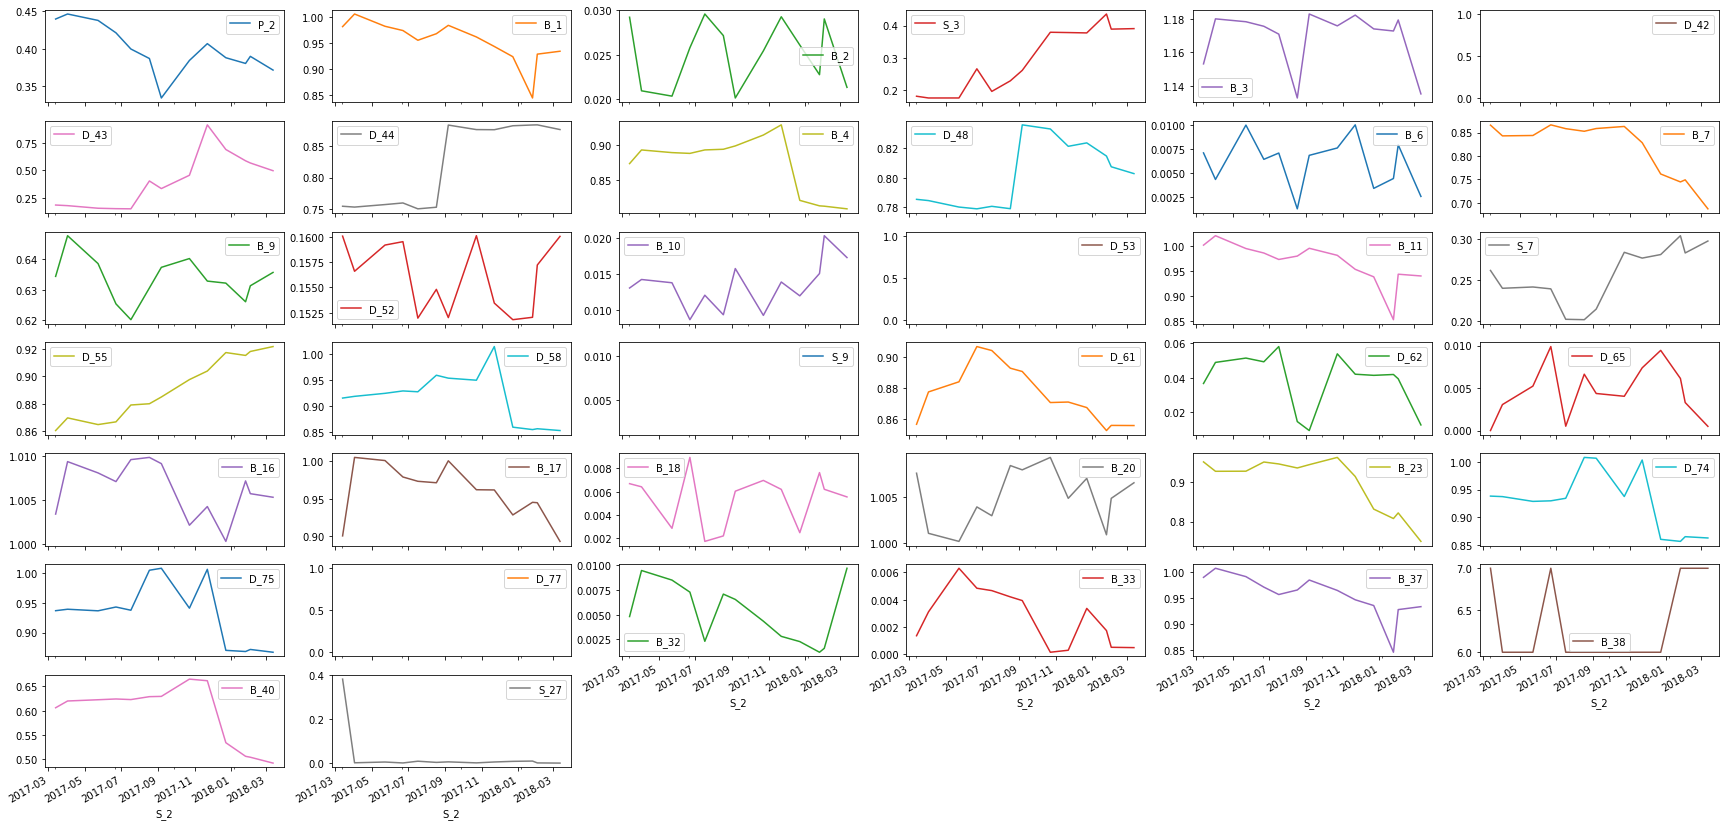

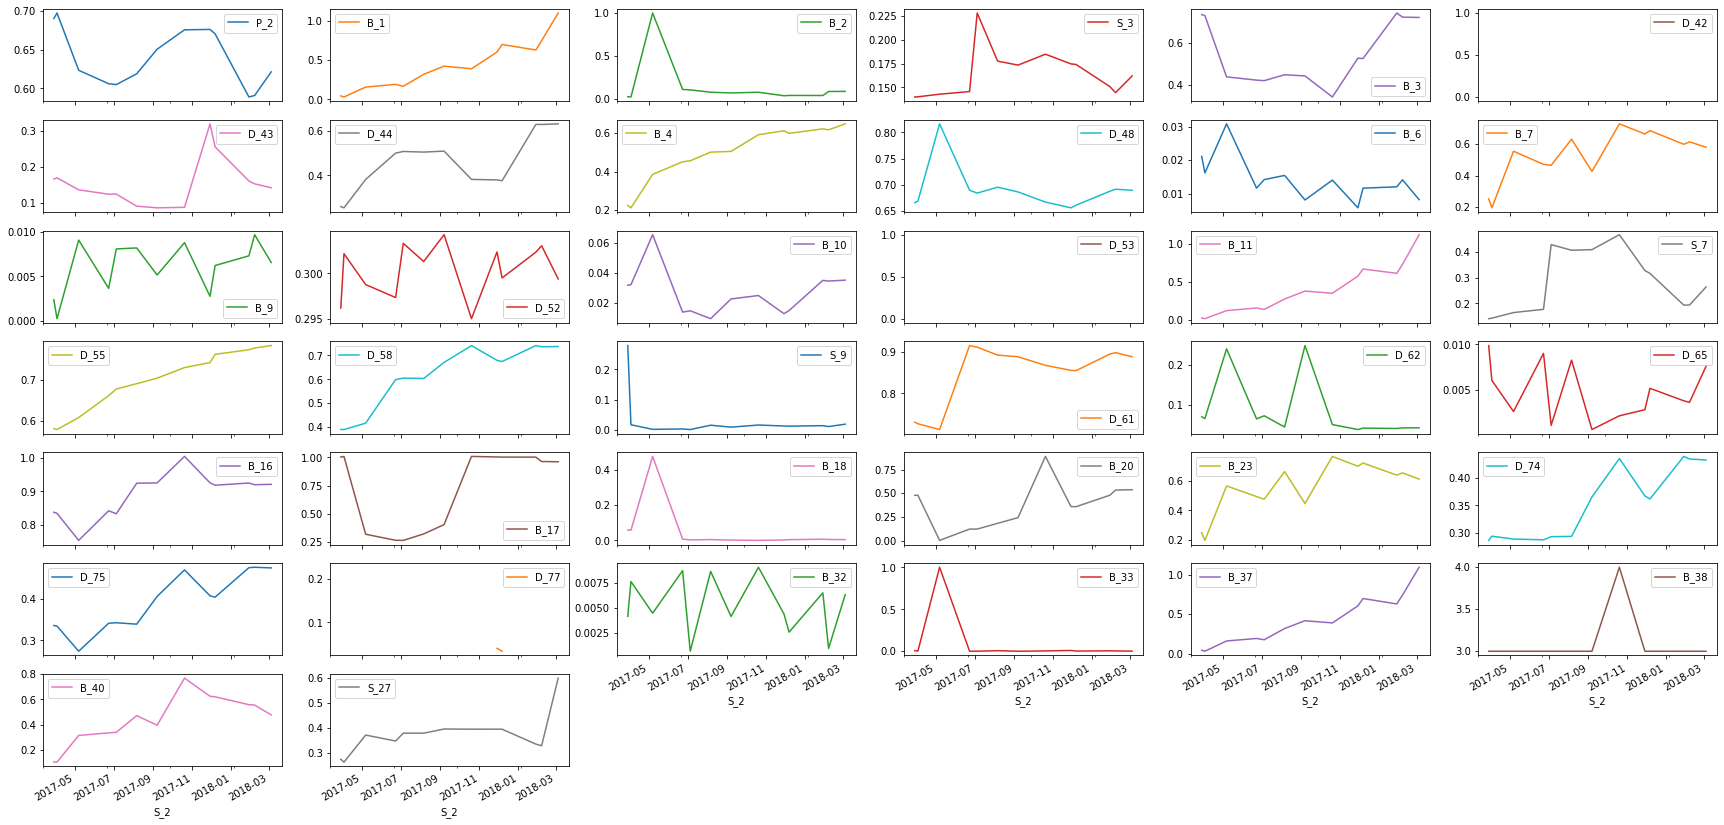

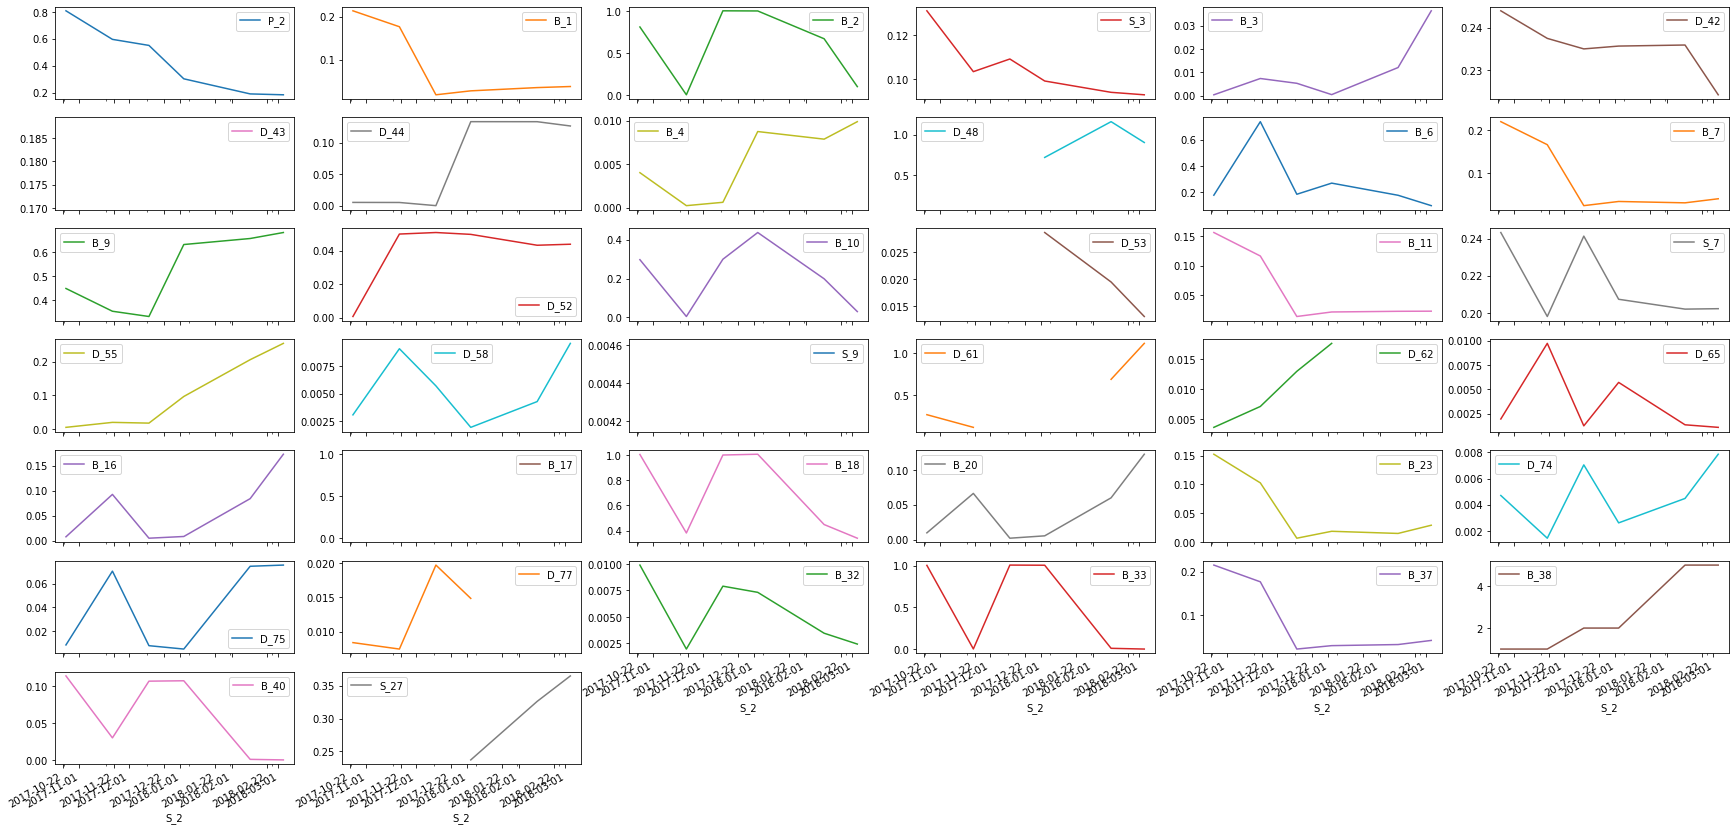

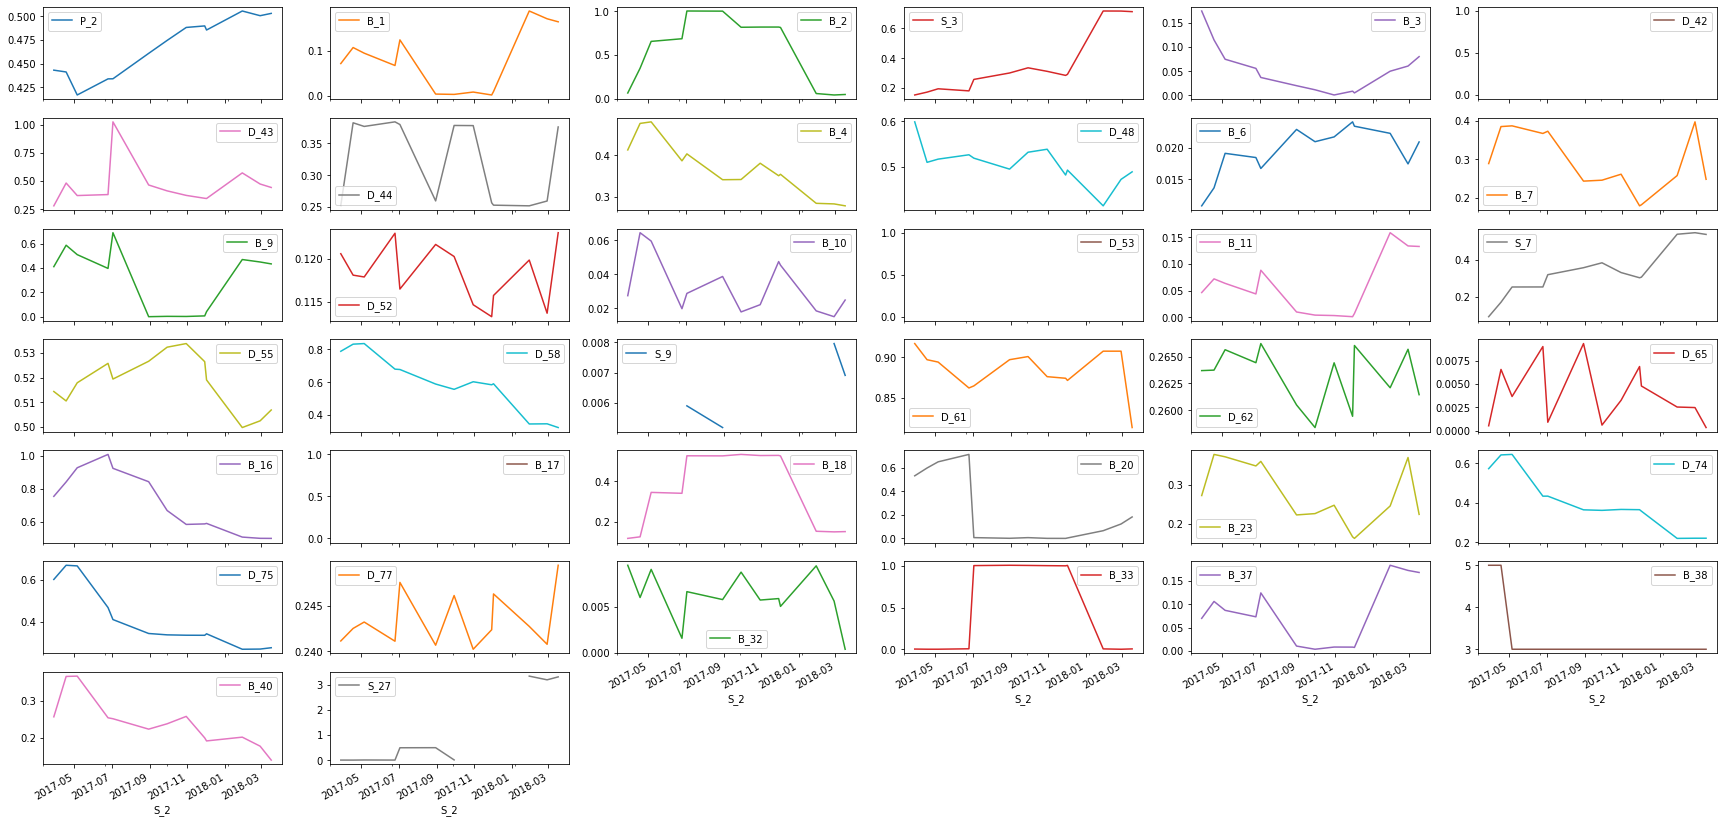

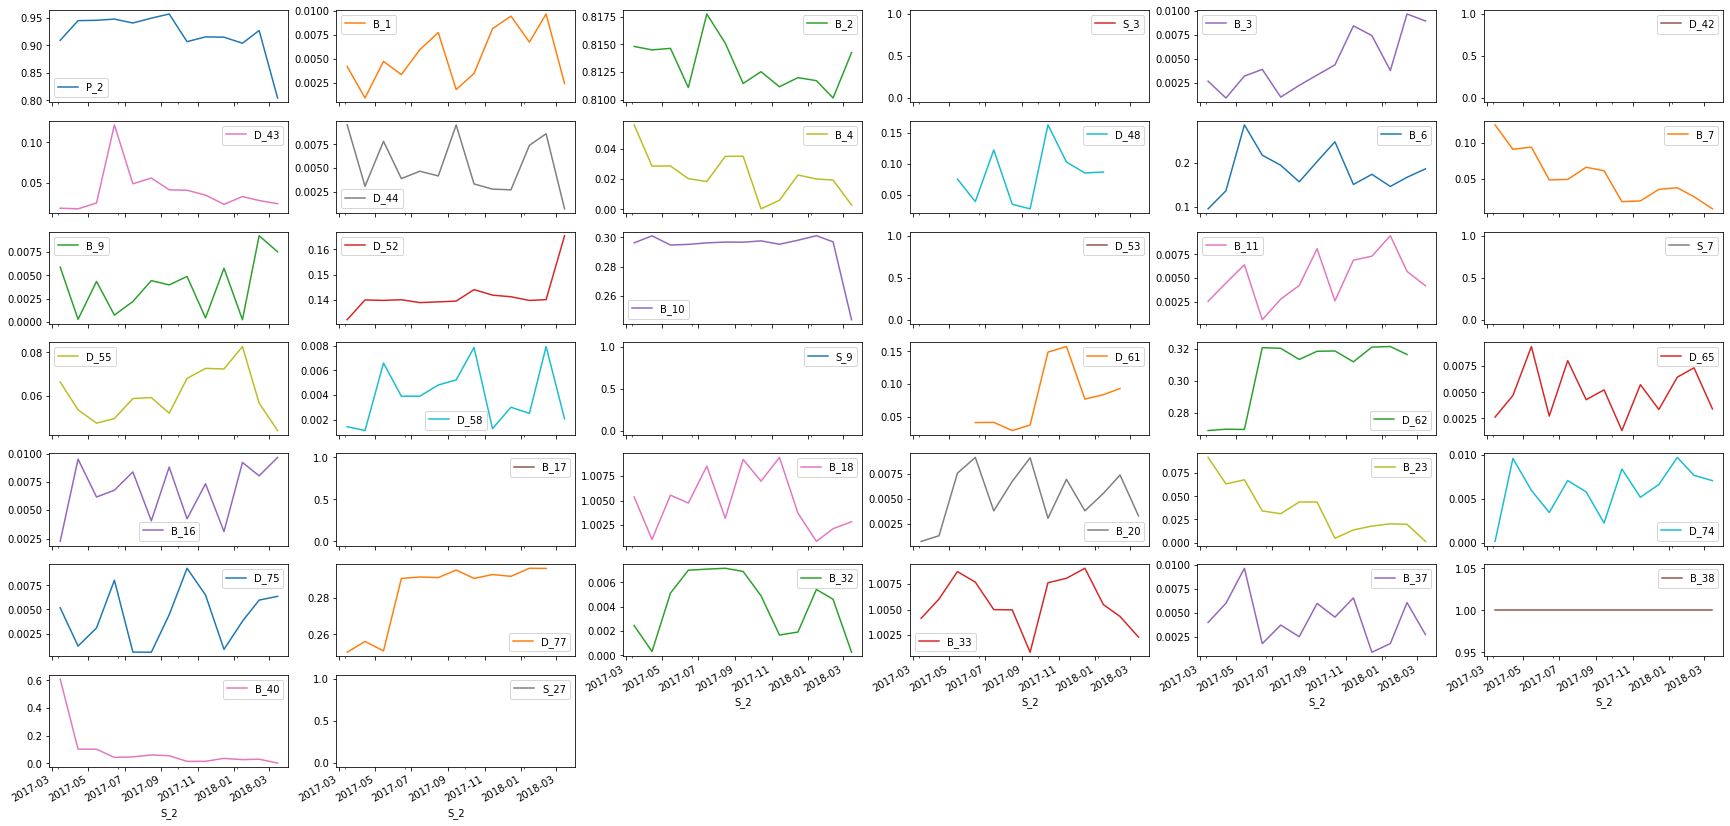

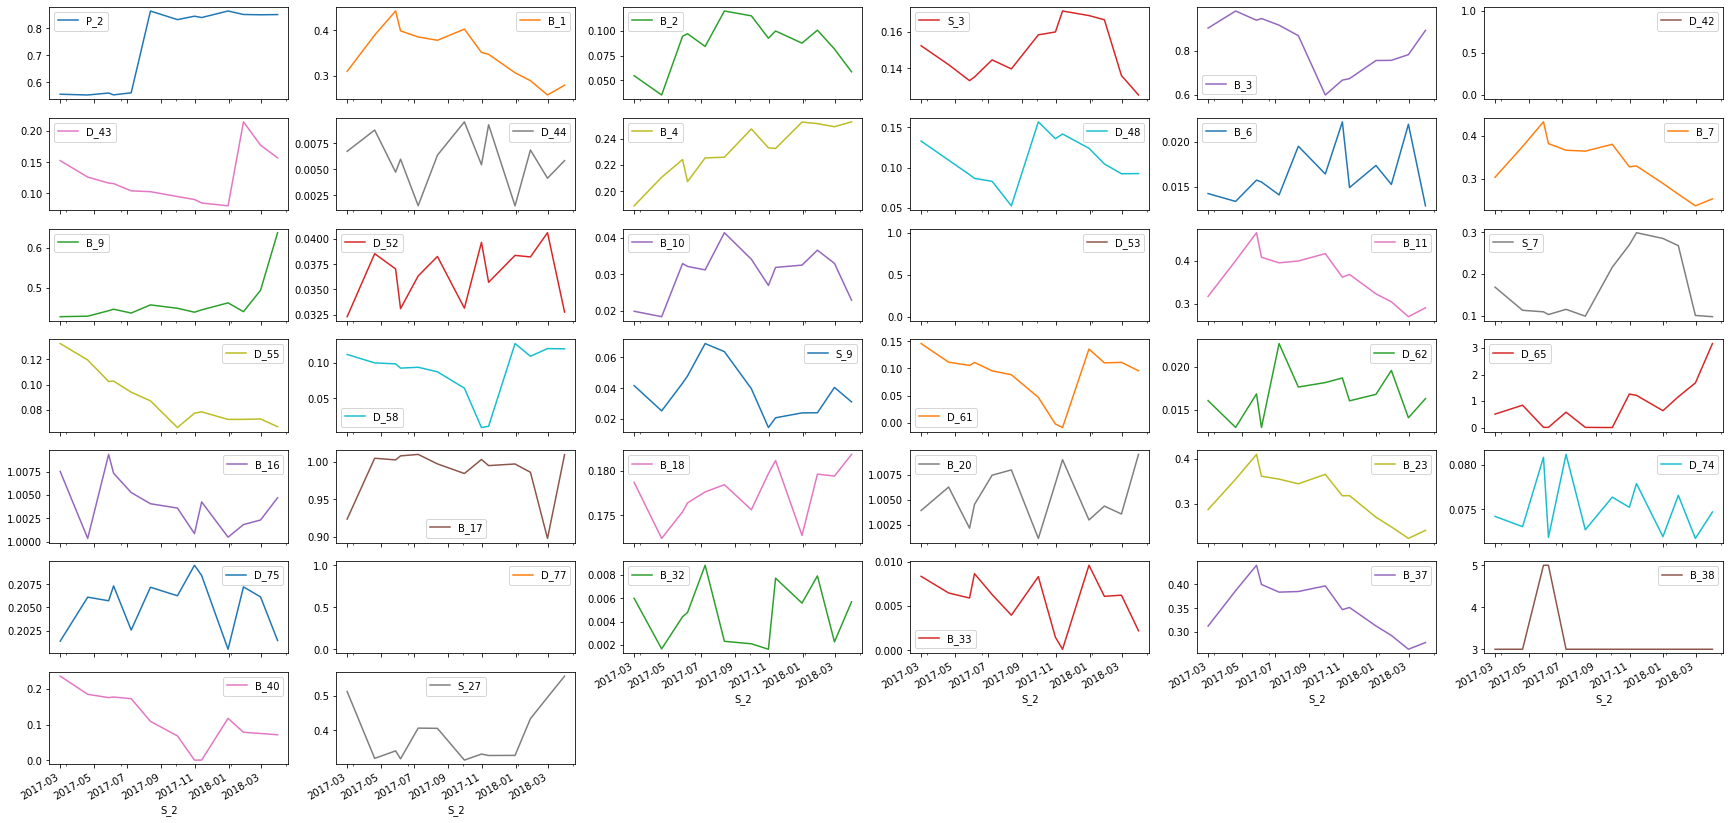

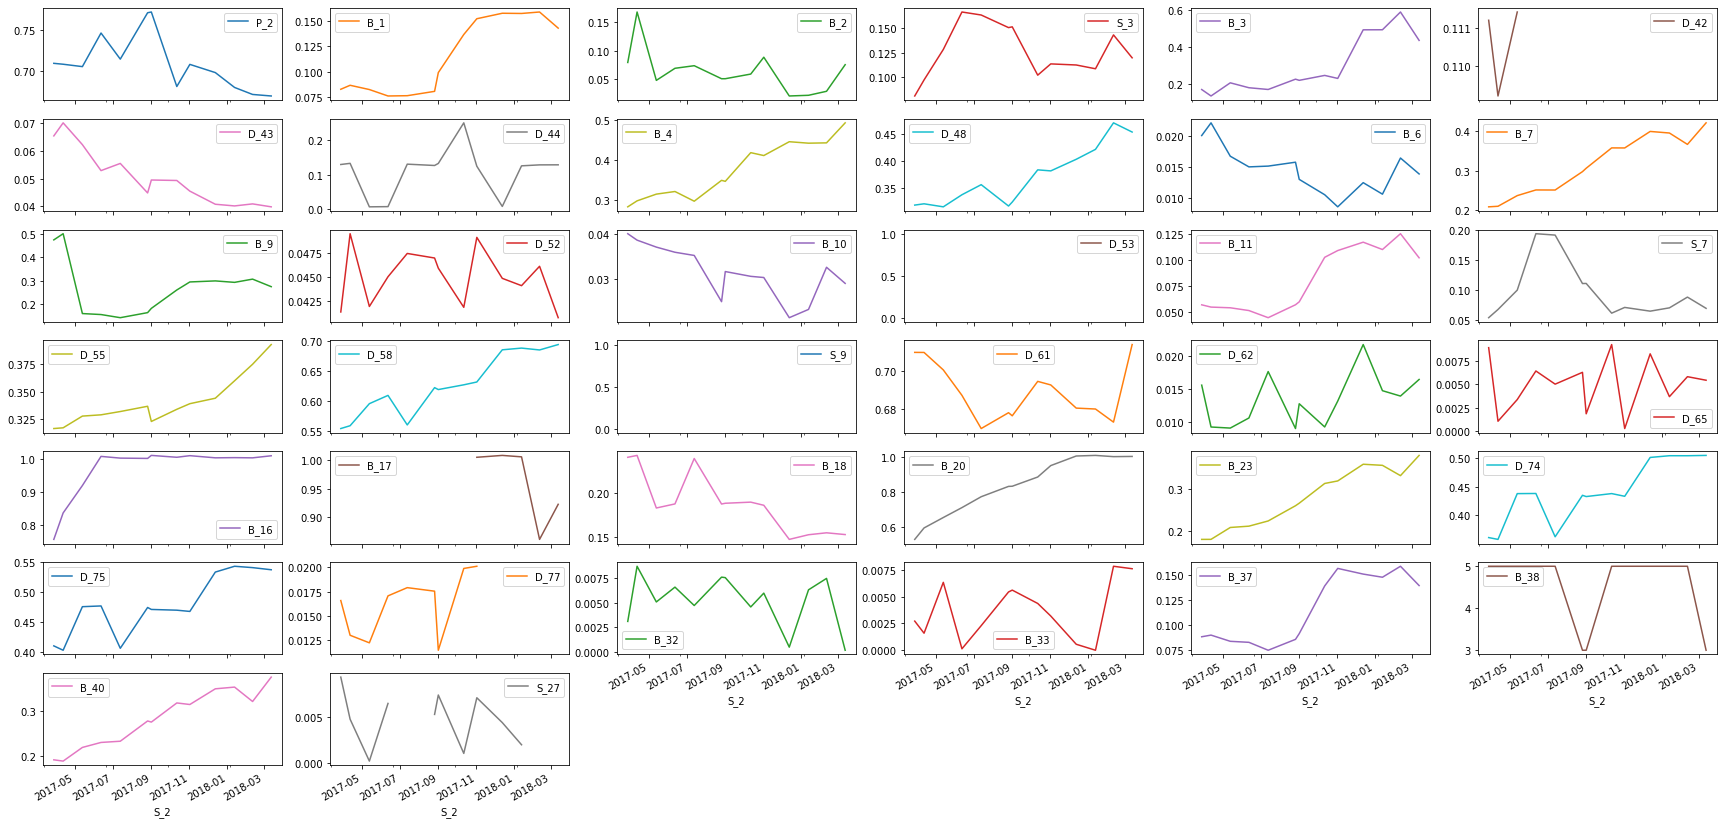

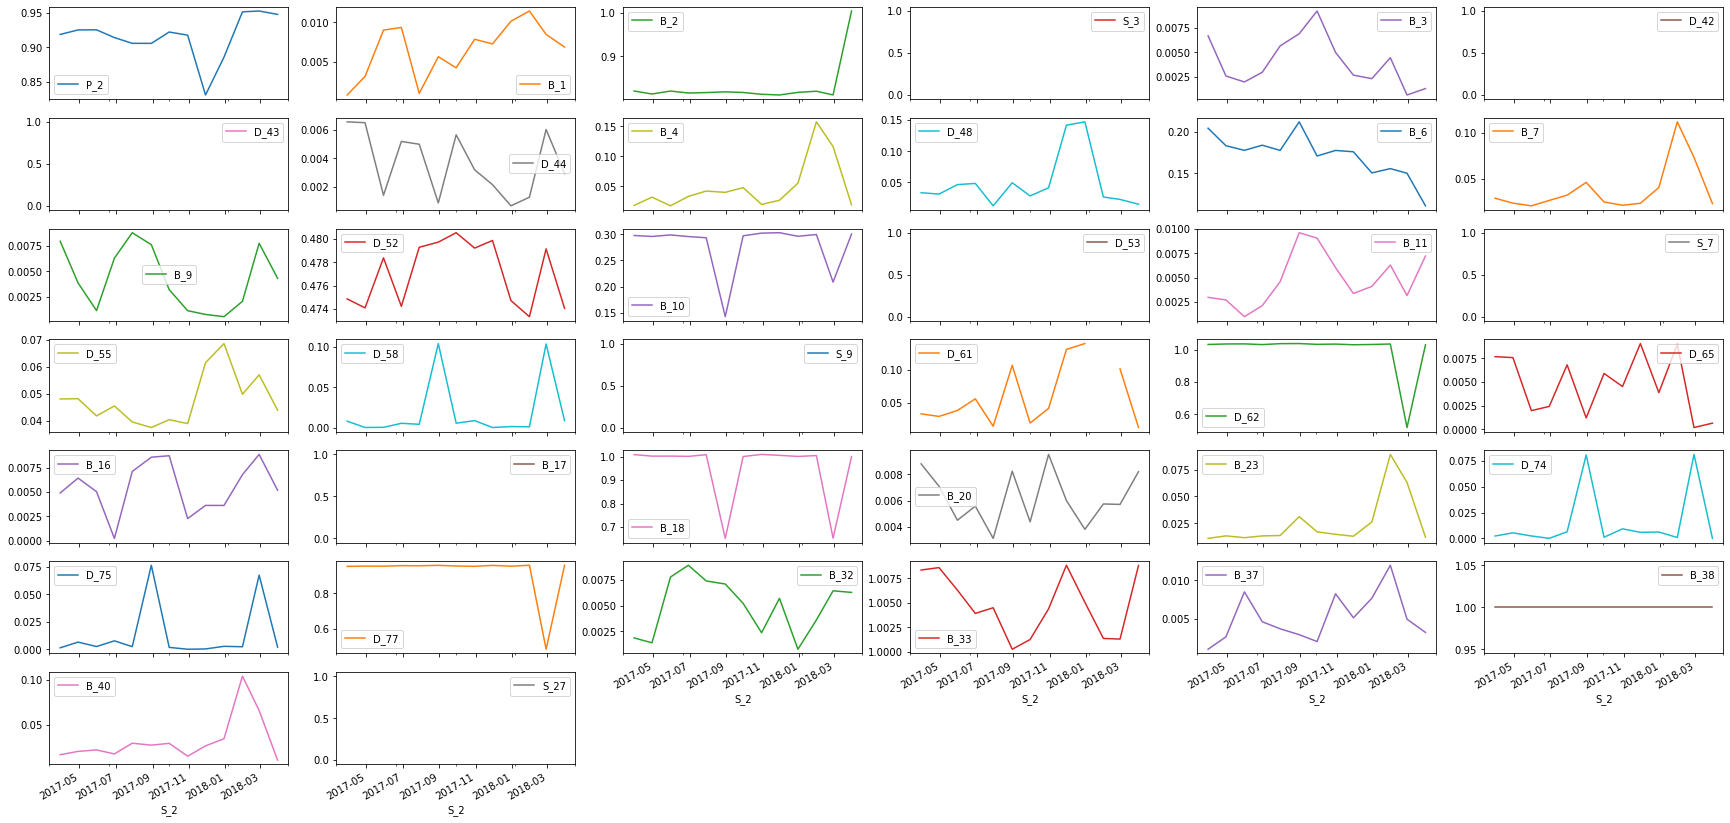

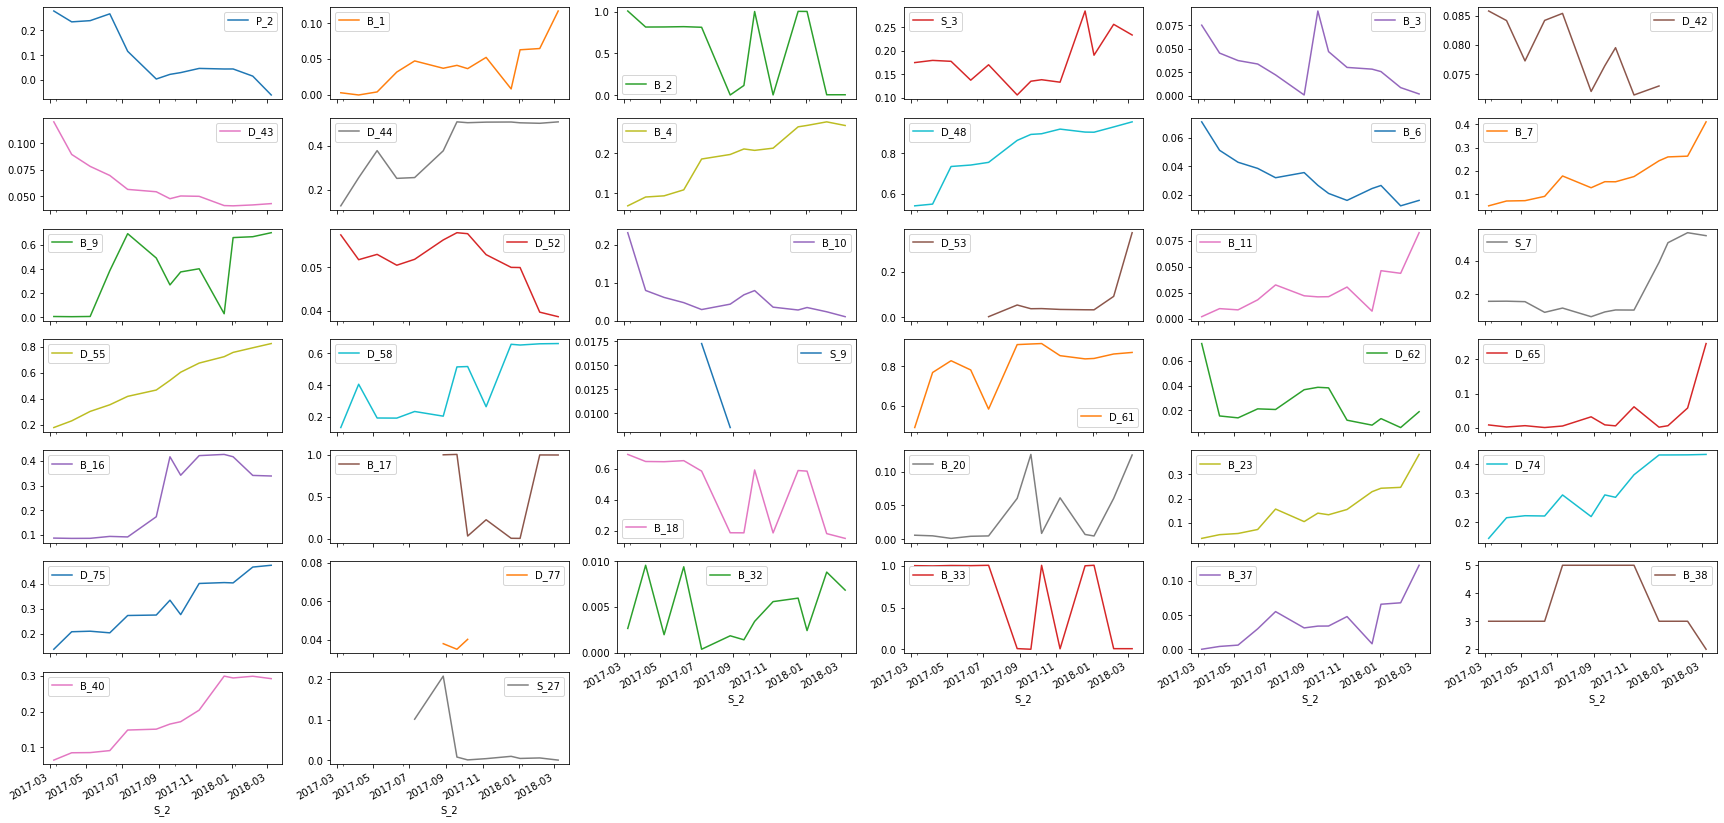

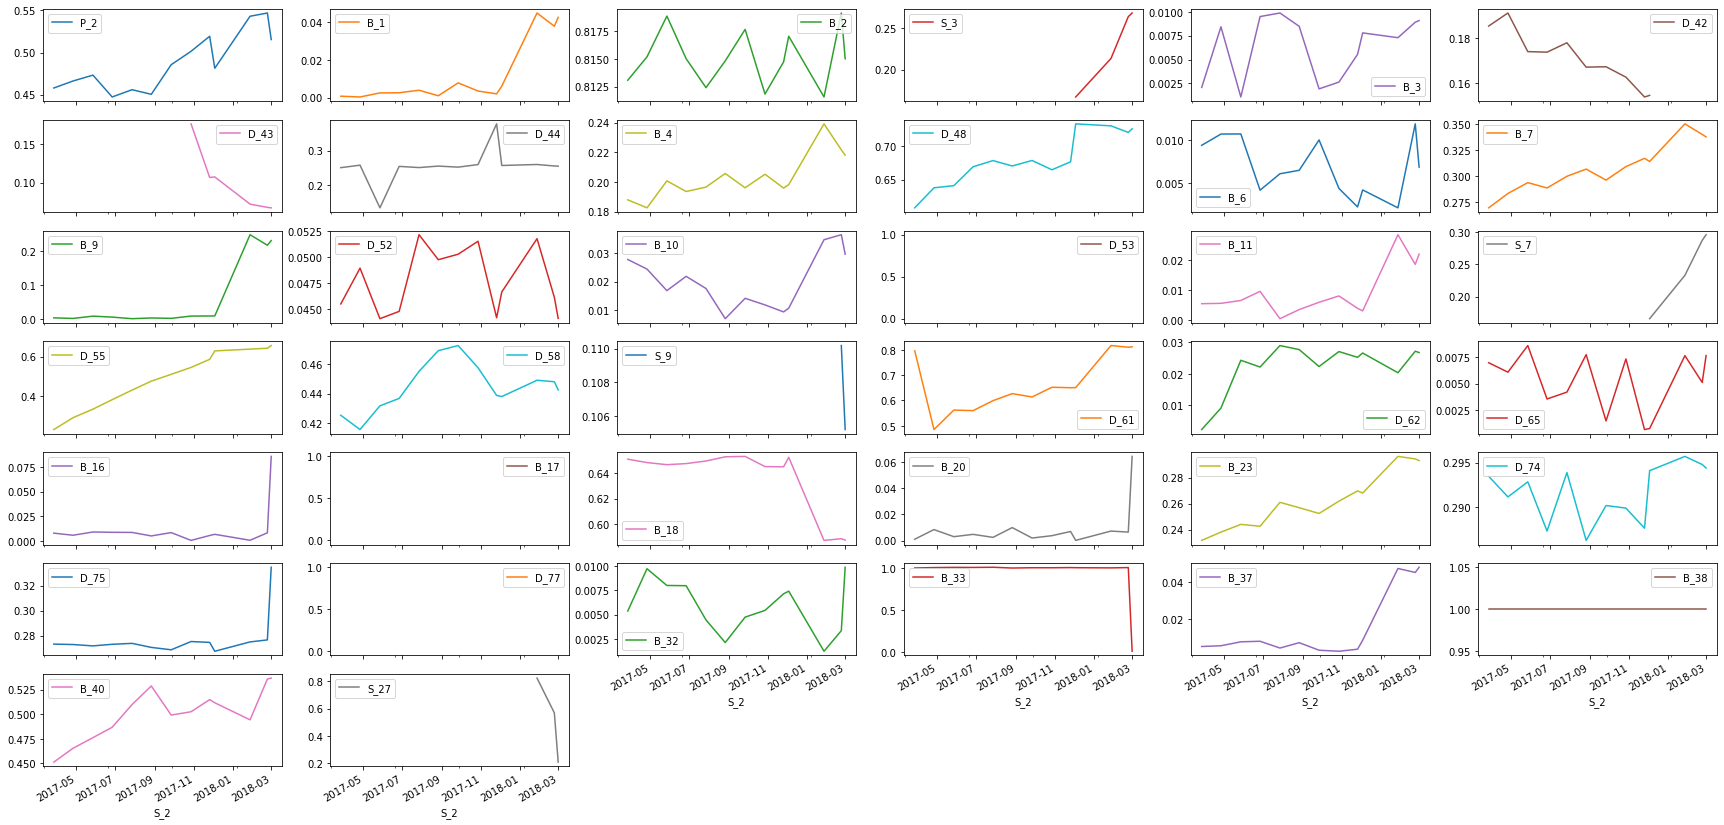

In [ ]:
# plotting = sample1.drop('customer_ID', axis=1).drop(mi_scores.tail(150).index, axis=1)
# id_sample = sample1.customer_ID.sample(10)

# for id in id_sample:
#     sample1.set_index('S_2').drop(mi_scores.tail(150).index, axis=1).loc[sample1.set_index('S_2')['customer_ID'] == id].drop('customer_ID', axis=1).plot(subplots=True, layout=(9, 6), figsize=(30, 20))

In [ ]:
# onehot = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='most_frequent')),
#     ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False))
# ])
# transformers = ColumnTransformer(transformers=[
#     ('cat', onehot, categoricals)
# ], remainder='passthrough')

In [52]:
class FloatImputer(BaseEstimator, TransformerMixin):
    def __init__(self):
        return
        
    def fill_group(self, group, col_defaults):
        for cname in group.columns:
            if group[cname].isna().all():
                group[cname].fillna(col_defaults[cname], inplace=True)

    def fit(self, X: pd.DataFrame, y = None):
        self.fitted_imputers = {}
        col_defaults = {cname : 0.0 for cname in X.columns}
        def fit_group(group: pd.DataFrame):
            self.fill_group(group, col_defaults)
            imp = SimpleImputer()
            self.fitted_imputers[group.index[0]] = imp.fit(group)
        X.groupby(X.index).apply(fit_group)
        return self
        
    def transform(self, X: pd.DataFrame, y = None):
        col_defaults = {cname : X[cname].mean() for cname in X.columns}
        def transform_group(group: pd.DataFrame):
            self.fill_group(group, col_defaults)
            return pd.DataFrame(self.fitted_imputers[group.index[0]].transform(group))
        transformed = X.groupby(X.index).apply(transform_group)
        return transformed.reset_index().set_index('customer_ID').drop('level_1', axis=1).set_axis(X.columns, axis=1)

In [53]:
imputer = FloatImputer()
imputer = imputer.fit(sample1.select_dtypes('float64').set_index(sample1['customer_ID']))

In [54]:
imputed = imputer.transform(sample1.select_dtypes('float64').set_index(sample1['customer_ID']))
imputed.head()

,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,D_42,D_43,...,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145
customer_ID,,,,,,,,,,,,,,,,,,,,,
001404030d4c78b76bf02e809387611bdf6b708a42c5890ecc057970b51bff87,0.523405,0.008376,0.006680,1.000940,0.003428,0.401315,0.007045,0.009355,0.185915,0.355097,...,0.252054,0.013747,0.137086,0.008365,0.008801,0.001185,0.396235,0.006018,0.009393,0.003585
001404030d4c78b76bf02e809387611bdf6b708a42c5890ecc057970b51bff87,0.533376,0.002836,0.007121,0.814569,0.001009,0.394459,0.000565,0.011885,0.185915,0.312375,...,0.252054,0.013747,0.137086,0.006429,0.000438,0.004144,0.396235,0.002282,0.003261,0.002704
001404030d4c78b76bf02e809387611bdf6b708a42c5890ecc057970b51bff87,0.634030,0.005452,0.004289,0.812784,0.000545,0.209648,0.004533,0.003436,0.185915,0.292273,...,0.252054,0.013747,0.137086,0.004221,0.007356,0.002904,0.396235,0.002599,0.005015,0.009224
001404030d4c78b76bf02e809387611bdf6b708a42c5890ecc057970b51bff87,0.581146,0.008479,0.058330,0.818535,0.001734,0.270682,0.005404,0.000965,0.185915,0.263852,...,0.252054,0.013747,0.137086,0.003387,0.001938,0.006487,0.396235,0.002336,0.004986,0.009904
001404030d4c78b76bf02e809387611bdf6b708a42c5890ecc057970b51bff87,0.638761,0.001563,0.074599,0.810576,0.003550,0.346932,0.002158,0.007989,0.185915,0.250307,...,0.252054,0.013747,0.137086,0.003324,0.009098,0.002901,0.396235,0.009378,0.004077,0.000444


In [59]:
print(len(sample1.customer_ID))
print(len(sample1.S_2))
len(imputed['P_2'])

55393
55393


55393

In [115]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler

class LinRegTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, ids, dates):
        # Assuming the dates column is sorted from earlier to later according to customer_ID, and there are no missing values
        self.ids = ids
        self.dates = dates
    def fit(self, X, y=None):
        # X is the column modeled by linear regression
        working = pd.DataFrame(self.dates).set_index(self.ids).set_axis(['time'], axis=1)
        self.fitted_models = {}
        def fit_models(group):
            scaler = MinMaxScaler(feature_range=(0, 1))
            time = scaler.fit_transform((group['time'] - group['time'].iloc[0]).dt.days.values.reshape(-1, 1)).reshape(1, -1)[0]
            regX = pd.DataFrame()
            for i in range(11):
                regX[f'poly{i}'] = time ** i
            model = LinearRegression(fit_intercept=False)
            model.fit(regX, group)
            self.fitted_models[group.index[0]] = model
        working.groupby(working.index).apply(fit_models)
        return self
    def transform(self, X, y=None):
        def transform_index(df):
            retframe = pd.DataFrame()
            coefs = self.fitted_models[df.index].coef_
            for i in range(len(coefs)):
                retframe[f'{X.columns[0]}_coef{i}'] = [coefs[i]]
            return retframe
        transformed = X.groupby(X.index).apply(transform_index)
        return transformed

In [116]:
a = LinRegTransformer(sample1.customer_ID, sample1.S_2)
a.fit(imputed['P_2'])

LinRegTransformer(dates=sampled_index
1532      2017-03-05
1533      2017-04-10
1534      2017-05-11
1535      2017-06-26
1536      2017-07-27
             ...    
5528460   2017-11-29
5528461   2017-12-10
5528462   2018-01-14
5528463   2018-02-02
5528464   2018-03-16
Name: S_2, Length: 55393, dtype: datetime64[ns],
                  ids=sampled_index
1532       001404030d4c78b76bf02e809387611bdf6b708a42c589...
1533       001404030d4c78b76bf02e809387611bdf6b70...
1536       001404030d4c78b76bf02e809387611bdf6b708a42c589...
                                 ...                        
5528460    ffdd918ab7fa2e12a597cbab79d08296114b6549b7bc39...
5528461    ffdd918ab7fa2e12a597cbab79d08296114b6549b7bc39...
5528462    ffdd918ab7fa2e12a597cbab79d08296114b6549b7bc39...
5528463    ffdd918ab7fa2e12a597cbab79d08296114b6549b7bc39...
5528464    ffdd918ab7fa2e12a597cbab79d08296114b6549b7bc39...
Name: customer_ID, Length: 55393, dtype: object)

In [ ]:
testdata = sample1.loc[sample1['customer_ID'] == "001404030d4c78b76bf02e809387611bdf6b708a42c5890ecc057970b51bff87"]
testdata

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145
sampled_index,,,,,,,,,,,,,,,,,,,,,
1532,001404030d4c78b76bf02e809387611bdf6b708a42c589...,2017-03-05,0.523405,0.008376,0.006680,1.000940,0.003428,0.401315,0.007045,0.009355,...,NaN,NaN,NaN,0.008365,0.008801,0.001185,NaN,0.006018,0.009393,0.003585
1533,001404030d4c78b76bf02e809387611bdf6b708a42c589...,2017-04-10,0.533376,0.002836,0.007121,0.814569,0.001009,0.394459,0.000565,0.011885,...,NaN,NaN,NaN,0.006429,0.000438,0.004144,NaN,0.002282,0.003261,0.002704
1534,001404030d4c78b76bf02e809387611bdf6b708a42c589...,2017-05-11,0.634030,0.005452,0.004289,0.812784,0.000545,0.209648,0.004533,0.003436,...,NaN,NaN,NaN,0.004221,0.007356,0.002904,NaN,0.002599,0.005015,0.009224
1535,001404030d4c78b76bf02e809387611bdf6b708a42c589...,2017-06-26,0.581146,0.008479,0.058330,0.818535,0.001734,0.270682,0.005404,0.000965,...,NaN,NaN,NaN,0.003387,0.001938,0.006487,NaN,0.002336,0.004986,0.009904
1536,001404030d4c78b76bf02e809387611bdf6b708a42c589...,2017-07-27,0.638761,0.001563,0.074599,0.810576,0.003550,0.346932,0.002158,0.007989,...,NaN,NaN,NaN,0.003324,0.009098,0.002901,NaN,0.009378,0.004077,0.000444
1537,001404030d4c78b76bf02e809387611bdf6b708a42c589...,2017-08-04,0.626389,0.005510,0.093220,1.005012,0.007855,0.344325,0.003301,0.005374,...,NaN,NaN,NaN,0.006948,0.006716,0.000593,NaN,0.002525,0.003236,0.008544
1538,001404030d4c78b76bf02e809387611bdf6b708a42c589...,2017-09-09,0.568308,0.177261,0.008241,0.924981,0.007415,0.339528,0.006952,0.001907,...,NaN,NaN,NaN,0.001333,0.006695,0.008091,NaN,0.007057,0.006917,0.006818
1539,001404030d4c78b76bf02e809387611bdf6b708a42c589...,2017-10-07,0.525137,0.123322,0.026830,0.221703,0.000433,0.327761,0.006850,0.030578,...,NaN,NaN,NaN,0.009595,0.007328,0.001727,NaN,0.009325,0.001333,0.007029
1540,001404030d4c78b76bf02e809387611bdf6b708a42c589...,2017-11-25,0.512799,0.009760,0.004936,0.222978,0.003275,0.327620,0.002129,0.045855,...,NaN,NaN,NaN,0.007893,0.004309,0.006504,NaN,0.002749,0.005765,0.005390


,coef0,coef1,coef2,coef3,coef4,coef5,coef6,coef7,coef8,coef9,coef10,coef11
0,6.521738e-12,4.666299e-11,-2.554560e-12,3.676127e-10,1.828009e-08,-3.123608e-10,2.013325e-12,-5.520416e-15,5.406312e-18,-1.352350e-21,4.297397e-22,2.828994e-22


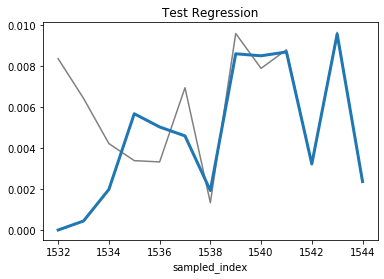

In [ ]:
import math
# Block for testing out linear regression
column = 'D_139'
# testdata.set_index((testdata['S_2'] - testdata['S_2'].iloc[0]).dt.days)
testregX = pd.DataFrame((testdata['S_2'] - testdata['S_2'].iloc[0]).dt.days, index=testdata.index)
for i in range(11):
    testregX[f'poly{i}'] = testregX['S_2'] ** i
model = LinearRegression(fit_intercept=False)
model.fit(testregX, testdata[column])
y_pred = pd.Series(model.predict(testregX), index=testregX.index)
testdata.set_index(column)
ax = testdata[column].plot(color='0.5', title='Test Regression')
_ = y_pred.plot(ax=ax, linewidth=3, label='Trend')

retframe = pd.DataFrame()
for i in range(len(model.coef_)):
    retframe[f'coef{i}'] = [model.coef_[i]]
retframe